서울 열린데이터광장 http://data.seoul.go.kr/dataList/OA-394/S/1/datasetView.do?tab=S  
서울시 주요 공원현황 자료다운
# 서울시 공원현황 분석


  - 공원 수 vs 구  
  - 공원 면적 vs 구 인구  
  - 공원 면적 vs 구 면적  
  - 공원 지도에 표시하기(공원 크기가 차이가 나도록)  
  - 강서구 지도에 공원 자세히 표시하기  
   \+자치구에 사용면적  

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

In [2]:
import folium
import json
geo_str = json.load(open('./data/skorea_municipalities_geo_simple.json', encoding='utf8'))                       

## 데이터 파악하고 정리하기
> ●  GRS80타원체(Geodetic Reference System 1980：측지기준계 1980)  
  국제학술단체에서 정의한 것,여러나라에서 지도제작 및 측지측량용으로 널리 사용  
●  WGS84타원체((World Geodetic System 1984)  
  미국에서 군사 및 GPS 운영을 목적으로 채택  
타원체로서의 GRS80과 WGS84와의 차이는 단반경이 약 0.1mm 다를 뿐이므로 실용적으로 동일한 것으로 취급하여 계산할 수 있습니다.  


In [3]:
park = pd.read_csv('./data/서울시 주요 공원현황.csv', encoding='CP949')[['공원명','면적','지역','공원주소','X좌표(WGS84)','Y좌표(WGS84)']]
park.head(3)

,공원명,면적,지역,공원주소,X좌표(WGS84),Y좌표(WGS84)
0,남산도시자연공원,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
1,길동생태공원,80683㎡,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
2,서울대공원,9132690m²,과천시,경기도 과천시 대공원광장로 102,127.019847,37.426449


In [4]:
# del park['공원번호']등등 컬럼삭제해도되지만.. 위에서 필요한 컬럼만 불러왔음
park.columns   

Index(['공원명', '면적', '지역', '공원주소', 'X좌표(WGS84)', 'Y좌표(WGS84)'], dtype='object')

In [5]:
park.info()
# 공원명, 공원주소는 132개인데
# 면적은 129개뿐(3개부족), 구별1개부족, 좌표1개부족..ㅠㅠ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   공원명         132 non-null    object 
 1   면적          129 non-null    object 
 2   지역          131 non-null    object 
 3   공원주소        132 non-null    object 
 4   X좌표(WGS84)  131 non-null    float64
 5   Y좌표(WGS84)  131 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.3+ KB


In [6]:
# 컬럼명변경
park.rename({'지역' : '구별','공원주소' : 'addr' , 'X좌표(WGS84)' : 'lng', 'Y좌표(WGS84)' : 'lat'}, inplace=True, axis=1)

In [7]:
#컬럼'면적'에 Nan값이 몇개 있는가?
park['면적'].isnull().sum()

3

In [8]:
#컬럼'면적'에 Nan값이 있는 행을 보여줘~~
park[park['면적'].isnull()]

,공원명,면적,구별,addr,lng,lat
109,푸른수목원,NaN,구로구,서울특별시 구로구 연동로 240(항동81-1) 푸른수목원관리사무소,126.824070,37.483029
119,문화역 서울284,NaN,중구,서울특별시 중구 통일로 1 서울역,126.971592,37.555872
131,서울로7017,NaN,중구,서울로7017,NaN,NaN


In [9]:
# park.drop([109],inplace=True) 인덱스로 3행을 삭제해도 됨. 
# df = park.dropna(axis=0, how='any') 결측치제거!! nan값모두삭제해버리는방법도있음ㅋㅋ나는 속시원하지만..쓰면 안돼;;;
#   컬럼면적에 NaN있으면 삭제하라! 3행 삭제되어  132>총129개로 변경
parkdf = park.dropna(subset=['면적'])
parkdf.info()
# '구별'만 128개로 1개부족하다! 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     129 non-null    object 
 1   면적      129 non-null    object 
 2   구별      128 non-null    object 
 3   addr    129 non-null    object 
 4   lng     129 non-null    float64
 5   lat     129 non-null    float64
dtypes: float64(2), object(4)
memory usage: 7.1+ KB


In [10]:
#컬럼'구별'에 Nan값이 있는 행을 보여줘~~
parkdf[parkdf['구별'].isnull()]

,공원명,면적,구별,addr,lng,lat
129,경춘선숲길,211392㎡,NaN,노원구 공릉2동 산 82-2,127.076482,37.627077


In [11]:
# 129번행의 컬럼구별에 '노원구'값 넣기
parkdf['구별'][129] = '노원구'
parkdf.info()       #오~ 모두129개확인완료! 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     129 non-null    object 
 1   면적      129 non-null    object 
 2   구별      129 non-null    object 
 3   addr    129 non-null    object 
 4   lng     129 non-null    float64
 5   lat     129 non-null    float64
dtypes: float64(2), object(4)
memory usage: 12.1+ KB


In [12]:
parkdf.head(10)   #면적의 데이터들....난감;;;

,공원명,면적,구별,addr,lng,lat
0,남산도시자연공원,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
1,길동생태공원,80683㎡,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
2,서울대공원,9132690m²,과천시,경기도 과천시 대공원광장로 102,127.019847,37.426449
3,서울숲,480994㎡,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072
4,월드컵공원,2284085㎡,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805
5,광화문시민열린마당,8948.1㎡,종로구,서울특별시 종로구 세종로 76-2,126.978023,37.575045
6,진관근린공원(구파발폭포),휴양 및 편익시설 : 평의자 7개 화장실 23.18㎡ 조경시설 - 은하폭포(높이 1...,은평구,서울특별시 은평구 진관동 393,126.919216,37.637024
7,중마루근린공원,6456㎥,영등포구,서울특별시 영등포구 영등포동2가 222,126.911267,37.519832
8,응봉공원,80309㎡ 배수지 시설용량 : 201.000㎥ 송수 펌프용량 : 직송급수계통 30...,성동구,서울특별시 성동구 금호동1가 산1-72,127.021765,37.557228
9,매화근린공원,1980.4㎡,강서구,서울특별시 강서구 등촌동 630-14,126.861150,37.557583


In [15]:
# 컬럼구별이 유니크한지 확인하는데.. 서울이 아닌, 과천시가 있다!! 
parkdf['구별'].unique()

array(['중구', '강동구', '과천시', '성동구', '마포구', '종로구', '은평구', '영등포구', '강서구',
       '동대문구', '동작구', '광진구', '용산구', '서대문구', '서초구', '관악구', '금천구', '성북구',
       '구로구', '양천구', '강남구', '송파구', '도봉구', '강북구', '중랑구', '노원구'],
      dtype=object)

In [16]:
# 과천시는 인덱스몇번인지 검색
parkdf[parkdf['구별'] == '과천시']

,공원명,면적,구별,addr,lng,lat
2,서울대공원,9132690m²,과천시,경기도 과천시 대공원광장로 102,127.019847,37.426449


In [17]:
# 인덱스2의 과천시 삭제
parkdf.drop([2], inplace=True)

In [18]:
parkdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     128 non-null    object 
 1   면적      128 non-null    object 
 2   구별      128 non-null    object 
 3   addr    128 non-null    object 
 4   lng     128 non-null    float64
 5   lat     128 non-null    float64
dtypes: float64(2), object(4)
memory usage: 7.0+ KB


In [83]:
parkdf.head(10)  #인덱스6 진관근린공원은 면적이 없다!!

,공원명,면적,구별,addr,lng,lat
0,남산도시자연공원,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
1,길동생태공원,80683㎡,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
3,서울숲,480994㎡,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072
4,월드컵공원,2284085㎡,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805
5,광화문시민열린마당,8948.1㎡,종로구,서울특별시 종로구 세종로 76-2,126.978023,37.575045
6,진관근린공원(구파발폭포),휴양 및 편익시설 : 평의자 7개 화장실 23.18㎡ 조경시설 - 은하폭포(높이 1...,은평구,서울특별시 은평구 진관동 393,126.919216,37.637024
7,중마루근린공원,6456㎥,영등포구,서울특별시 영등포구 영등포동2가 222,126.911267,37.519832
8,응봉공원,80309㎡ 배수지 시설용량 : 201.000㎥ 송수 펌프용량 : 직송급수계통 30...,성동구,서울특별시 성동구 금호동1가 산1-72,127.021765,37.557228
9,매화근린공원,1980.4㎡,강서구,서울특별시 강서구 등촌동 630-14,126.861150,37.557583
10,성수근린공원,5197.7㎡,성동구,서울특별시 성동구 성수2가 3동 302-25,127.052402,37.544814


In [84]:
parkdf.drop([6], inplace=True)
parkdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     127 non-null    object 
 1   면적      127 non-null    object 
 2   구별      127 non-null    object 
 3   addr    127 non-null    object 
 4   lng     127 non-null    float64
 5   lat     127 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.9+ KB


In [87]:
#면적부분 정리과정
a_l = []
for i in parkdf.index:
    a = parkdf['면적'].str.split('㎡')[i][0]  
    a = a.strip('㎥ ')
    a = a.strip('m²')
    a = a.strip('총 ')
    a_l.append(a.replace('m2',''))

In [88]:
a_l

['2896887',
 '80683',
 '480994',
 '2284085',
 '8948.1',
 '6456',
 '80309',
 '1980.4',
 '5197.7',
 '11467',
 '229539',
 '15179.7',
 '16734.60',
 '61544',
 '424106',
 '560552',
 '26696.8',
 '75900',
 '113021.7',
 '201779',
 '258991',
 '10420819.08',
 '171294.1',
 '15000',
 '297926',
 '411972',
 '98470',
 '2038741.3',
 '603715.2',
 '108120',
 '29619.3',
 '29843.8',
 '126026',
 '135002.7',
 '384026',
 '180000',
 '416031',
 '160720',
 '2277252',
 '19599.70',
 '138596',
 '185295',
 '254648',
 '29816.5',
 '762642',
 '664905',
 '99599.9',
 '5802',
 '16500',
 '585652',
 '649709.6',
 '72132',
 '66027.8',
 '265582',
 '2088704.9',
 '112070',
 '993724',
 '219167',
 '1349556.4',
 '1511198',
 '1097565',
 '328018',
 '1447122',
 '207790',
 '1018689',
 '954553',
 '1667848',
 '13224',
 '130345',
 '5332422',
 '5107964',
 '47832',
 '213552',
 '168099.87',
 '359435.2',
 '36660',
 '380735',
 '1807420.9',
 '359342.8',
 '632733',
 '328018',
 '6691885.3',
 '285757',
 '110407',
 '29682.2',
 '137759',
 '917190',


In [92]:
parkdf['면적'] = a_l # 컬럼면적 전처리한 부분을 다시 대입
parkdf

,공원명,면적,구별,addr,lng,lat
0,남산도시자연공원,2896887,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
1,길동생태공원,80683,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
3,서울숲,480994,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072
4,월드컵공원,2284085,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805
5,광화문시민열린마당,8948.1,종로구,서울특별시 종로구 세종로 76-2,126.978023,37.575045
...,...,...,...,...,...,...
126,서일대뒷산공원,631021,중랑구,서울특별시 중랑구 면목동 산19,127.098782,37.587716
127,용마도시자연공원(사가정공원),109635,중랑구,서울특별시 중랑구 면목7동 산50,127.095997,37.579762
128,문화비축기지,140022,마포구,서울특별시 마포구 증산로 87,126.893245,37.571718
129,경춘선숲길,211392,노원구,노원구 공릉2동 산 82-2,127.076482,37.627077


In [93]:
parkdf.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     127 non-null    object 
 1   면적      127 non-null    object 
 2   구별      127 non-null    object 
 3   addr    127 non-null    object 
 4   lng     127 non-null    float64
 5   lat     127 non-null    float64
dtypes: float64(2), object(4)
memory usage: 11.9+ KB


In [98]:
#컬럼면적부분 dtype을 object에서 float으로 변경
df = parkdf.astype({'면적':'float'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 130
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     127 non-null    object 
 1   면적      127 non-null    float64
 2   구별      127 non-null    object 
 3   addr    127 non-null    object 
 4   lng     127 non-null    float64
 5   lat     127 non-null    float64
dtypes: float64(3), object(3)
memory usage: 6.9+ KB


In [100]:
pd.pivot_table(df, index=['구별', '공원명'])

lat         lng         면적
구별  공원명                                              
강남구 광평근린공원           37.488045  127.092184   519782.0
    대모산도시자연공원        37.479649  127.080964  2277252.0
    도곡근린공원           37.490313  127.045034   254648.0
    도산근린공원           37.524675  127.035030    29816.5
    봉은공원             37.513903  127.055496   328018.0
...                        ...         ...        ...
중랑구 봉화산근린공원          37.610640  127.092362  1018689.0
    서일대뒷산공원          37.587716  127.098782   631021.0
    용마도시자연공원(사가정공원)  37.579762  127.095997   109635.0
    용마폭포공원           37.573197  127.090589  5107964.0
    중랑캠핑숲            37.604990  127.109307   179666.0

[127 rows x 3 columns]

In [105]:
#인구수 가진 데이터 불러오기
pop = pd.read_csv('./results/01.cctv.csv', encoding='utf8',index_col='구별')[['인구수']]
pop.head()

,인구수
구별,
강남구,544085
강동구,462275
강북구,313550
강서구,589536
관악구,514555


In [111]:
#컬럼추가   
pop['공원수'] = df['구별'].value_counts()
pop['공원면적'] = df.groupby('구별')['면적'].sum()
pop.head()

,인구수,공원수,공원면적
구별,,,
강남구,544085,7,3626398.50
강동구,462275,7,1526389.30
강북구,313550,4,3714902.40
강서구,589536,9,2194154.10
관악구,514555,2,10431453.08


In [114]:
fp1 =np.polyfit(pop['인구수'], pop['공원수'], 1)
fp1

array([2.03842835e-06, 4.26846017e+00])

In [115]:
f1 = np.poly1d(fp1)
fx = np.linspace(100000, 700000, 100)
fy = f1(fx)

In [116]:
pop['오차'] = np.abs(pop['공원수'] - f1(pop['인구수']))
pop_sort = pop.sort_values('오차', ascending=False)
pop_sort.head()

,인구수,공원수,공원면적,오차
구별,,,,
종로구,159842,12,3907680.57,7.405713
강서구,589536,9,2194154.10,3.529813
관악구,514555,2,10431453.08,3.317344
광진구,361923,2,584002.00,3.006214
용산구,244953,2,247194.10,2.767779


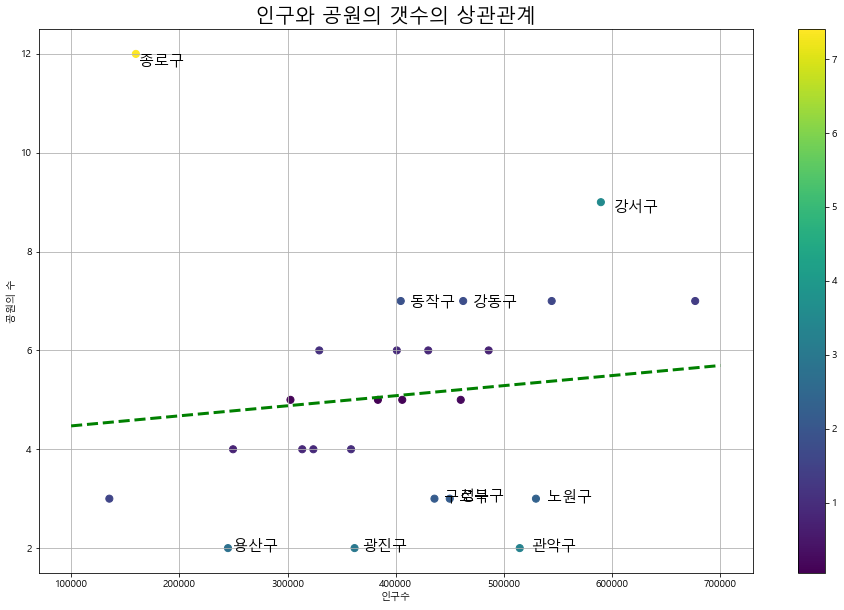

In [118]:
plt.figure(figsize=(16,10))
plt.scatter(pop['인구수'], pop['공원수'], c=pop['오차'], s=50)
for i in range(10): 
    plt.text(pop_sort['인구수'][i]*1.02, pop_sort['공원수'][i]*0.98,
             pop_sort.index[i], fontsize=15)
plt.plot(fx,fy,ls='dashed', lw=3, color='g')
plt.grid(True)
plt.title('인구와 공원의 갯수의 상관관계', fontsize=20)
plt.xlabel('인구수')
plt.ylabel('공원의 수')
plt.colorbar()    
plt.show()

#### 이정도 기울기도 정비례한다고 볼수 있나...? 인구에 비해 종로구가 공원이 제일 많다!

In [120]:
area =pd.read_table('./data/서울시행정구역(구별).txt', header=1)[['자치구','면적']]
area.head()

,자치구,면적
0,서울시,605.24
1,종로구,23.91
2,중구,9.96
3,용산구,21.87
4,성동구,16.86


In [122]:
# 서울시전체 면적은 필요없으니 삭제
area.drop([0], inplace=True)

In [123]:
area.rename({'자치구':'구별'}, inplace=True, axis=1)
area.set_index('구별', inplace=True)
area.head()

,면적
구별,
종로구,23.91
중구,9.96
용산구,21.87
성동구,16.86
광진구,17.06


In [124]:
pop['구면적'] = area['면적']
pop.head()

,인구수,공원수,공원면적,오차,구면적
구별,,,,,
강남구,544085,7,3626398.50,1.622462,39.50
강동구,462275,7,1526389.30,1.789225,24.59
강북구,313550,4,3714902.40,0.907609,23.60
강서구,589536,9,2194154.10,3.529813,41.44
관악구,514555,2,10431453.08,3.317344,29.57


In [125]:
fp1 =np.polyfit(pop['구면적'], pop['공원면적'], 1)
fp1

array([  223419.04664711, -2046497.14170783])

In [126]:
f1 = np.poly1d(fp1)
fx = np.linspace(10, 50, 100)
fy = f1(fx)

In [128]:
pop['오차'] = np.abs(pop['공원면적'] - f1(pop['구면적']))
pop_sort = pop.sort_values('오차', ascending=False)
pop_sort.head()

,인구수,공원수,공원면적,오차,구면적
구별,,,,,
노원구,529532,3,12235699.30,6.364225e+06,35.44
관악구,514555,2,10431453.08,5.871449e+06,29.57
강서구,589536,9,2194154.10,5.017834e+06,41.44
중랑구,400989,6,7078975.00,4.992220e+06,18.50
서초구,429995,6,13359636.00,4.909906e+06,46.98


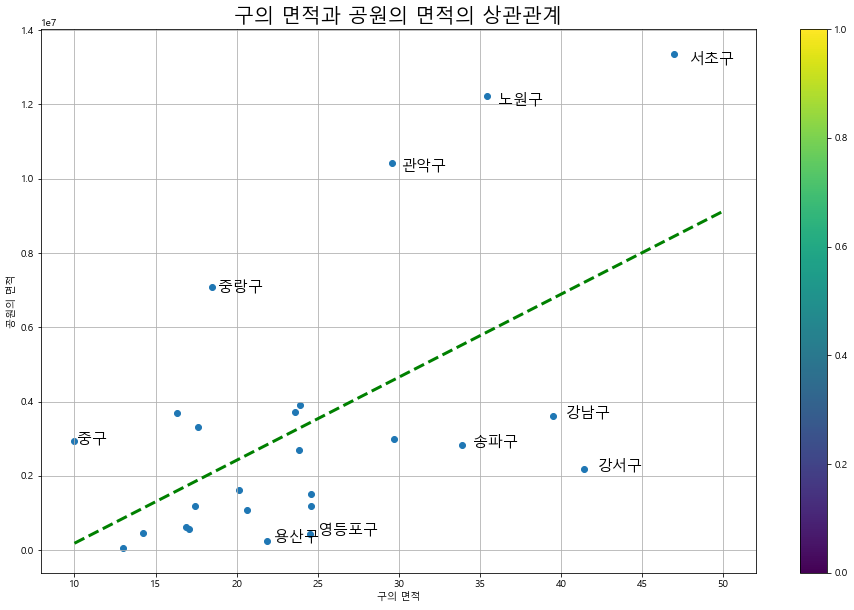

In [130]:
plt.figure(figsize=(16,10))
plt.scatter(pop['구면적'], pop['공원면적'])
plt.grid(True)
plt.plot(fx,fy, ls='dashed', lw=3, color ='g')
for i in range(10): 
    plt.text(pop_sort['구면적'][i]*1.02, pop_sort['공원면적'][i]*0.98,
             pop_sort.index[i], fontsize=15)
plt.title('구의 면적과 공원의 면적의 상관관계', fontsize=20)
plt.xlabel('구의 면적')
plt.ylabel('공원의 면적')
plt.colorbar()    
plt.show()

#### 전체적으로 정비례하다. 강서구는 구의면적에 비해 공원면적이 적다.

In [131]:
df = df.reset_index()

In [132]:
del df['index']

In [134]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles='Stamen Toner')
for i in df.index:
    folium.CircleMarker([df.lat[i], df.lng[i]], 
                        tooltip=df['공원명'][i], radius= df['면적'][i]*0.000002,color='#3186cc', fill_color='#3186cc').add_to(map)


title_html = '''
             <h3 align="center" style="font-size:20px"><b>서울의 모든 공원 크기별로 표시하기</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))                      
map

In [135]:
map = folium.Map(location=[df[df['구별']=='강서구']['lat'].mean(),
df[df['구별']=='강서구']['lng'].mean()], zoom_start=13)
for i in df[df['구별']=='강서구'].index:
    folium.Marker([df.lat[i], df.lng[i]], popup=df['공원명'][i],
                        tooltip=df['면적'][i]).add_to(map)
                        
title_html = '''
             <h3 align="center" style="font-size:20px"><b>강서구의 공원들</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [10]:
use = pd.read_csv('./data/서울시 용도지역 현황통계.txt', delimiter = '\t',header=3)[['자치구','소계']]
use.head()

,자치구,소계
0,서울특별시,"325,969,607"
1,종로구,"9,830,838"
2,중구,"6,037,439"
3,용산구,"12,107,810"
4,성동구,"9,947,641"


In [11]:
use.drop([0],inplace=True)
use.head()

,자치구,소계
1,종로구,"9,830,838"
2,중구,"6,037,439"
3,용산구,"12,107,810"
4,성동구,"9,947,641"
5,광진구,"11,596,961"


In [12]:
use.reset_index(drop=True,inplace=True)
use.head()

,자치구,소계
0,종로구,"9,830,838"
1,중구,"6,037,439"
2,용산구,"12,107,810"
3,성동구,"9,947,641"
4,광진구,"11,596,961"


In [13]:
use['자치구'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'], dtype=object)

In [14]:
use['자치구'].count()

25

In [15]:
# 빈칸 찾기
use.isnull().any() 

자치구    False
소계     False
dtype: bool